<a href="https://colab.research.google.com/github/eemmy2547/229352/blob/main/Lab10_CNNs_660510779.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [2]:
!unzip -q pizza_steak_sushi.zip

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

Class names: ['pizza', 'steak', 'sushi']
Class to index mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}
Number of training samples: 225
Number of testing samples: 75
Number of batches in training DataLoader: 8
Number of batches in testing DataLoader: 1


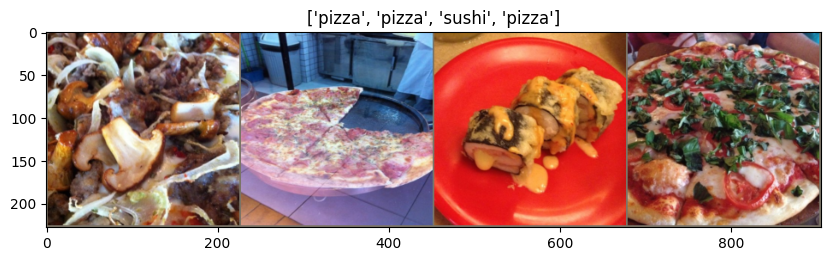

In [3]:
# 1. Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = datasets.ImageFolder(root="train",
                                  transform=data_transforms) # Write your code here
test_data = datasets.ImageFolder(root="test",
                                 transform=data_transforms) # Write your code here

# Get class names and their mapping
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# 3. Create DataLoaders
BATCH_SIZE = 32 # You can experiment with different batch sizes

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)  # Write your code here

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=len(test_data),
                             shuffle=False)  # Write your code here

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [4]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        # Write your code here
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 53 * 53, 120) # Calculate input features based on image size and conv/pool operations
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        # Write your code here
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

lenet_model = LeNet(num_classes=3)

In [5]:
lenet_model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [7]:
# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Training phase
        model.train() # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # Write your code here
            # 1. Move inputs and labels to device
            x = inputs.to(device)
            y = labels.to(device)

            # 2. Zero the gradient
            optimizer.zero_grad()

            # 3. Make predictions
            y_pred = model(x)

            # 4. Calculate the loss
            loss = criterion(y_pred, y)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update model's parameters
            optimizer.step()

            # Calculate total loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(y_pred.data, 1) # Corrected to use y_pred
            train_total += labels.size(0)
            train_correct += (predicted == y).sum().item() # Corrected to use y

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # Evaluation phase
        model.eval() # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad(): # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    return results

In [8]:
# Instantiate LeNet model
lenet_model = LeNet(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
print(lenet_model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (act3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): ReLU()
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [9]:
# Train the LeNet model
lenet_model.to(device) # Ensure the model is on the correct device
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0353, Train Acc: 0.4622 | Test Loss: 0.9780, Test Acc: 0.4400
Epoch 2/10 - Train Loss: 0.8520, Train Acc: 0.5511 | Test Loss: 1.2361, Test Acc: 0.4267
Epoch 3/10 - Train Loss: 0.8549, Train Acc: 0.5689 | Test Loss: 1.0436, Test Acc: 0.4267
Epoch 4/10 - Train Loss: 0.6902, Train Acc: 0.6933 | Test Loss: 0.9953, Test Acc: 0.4800
Epoch 5/10 - Train Loss: 0.5721, Train Acc: 0.7689 | Test Loss: 1.0923, Test Acc: 0.4933
Epoch 6/10 - Train Loss: 0.7045, Train Acc: 0.7067 | Test Loss: 1.3184, Test Acc: 0.4133
Epoch 7/10 - Train Loss: 0.4495, Train Acc: 0.8533 | Test Loss: 1.1725, Test Acc: 0.4667
Epoch 8/10 - Train Loss: 0.3167, Train Acc: 0.8889 | Test Loss: 1.4473, Test Acc: 0.5200
Epoch 9/10 - Train Loss: 0.2447, Train Acc: 0.9111 | Test Loss: 1.2895, Test Acc: 0.4933
Epoch 10/10 - Train Loss: 0.2196, Train Acc: 0.9111 | Test Loss: 2.8075, Test Acc: 0.4267


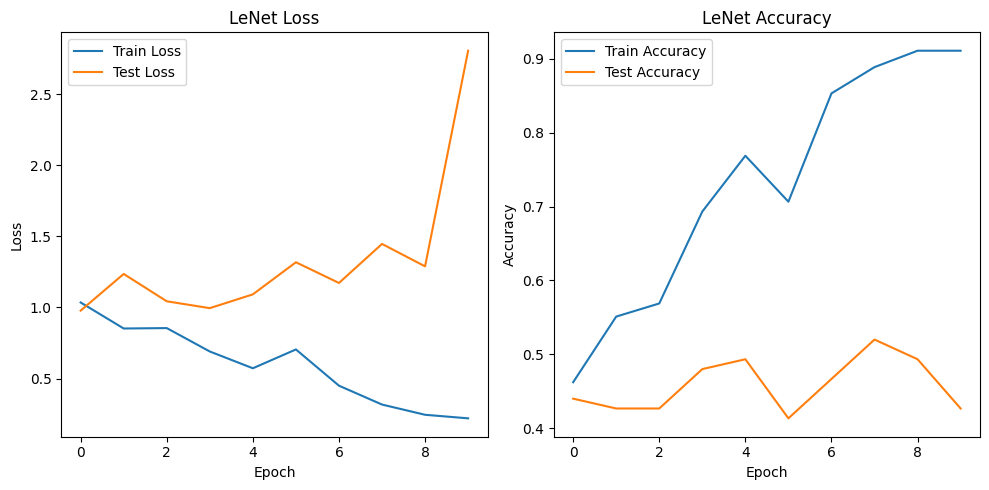

In [10]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:**

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [11]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)
print("Original EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 163MB/s]

Original EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [12]:
efficientnet_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
efficientnet_model.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [15]:
# 2. Freeze all parameters in the feature extractor part
#### Write your code here
for param in efficientnet_model.features.parameters():
  param.requires_grad = False

# 3. Modify the classifier head for 3 classes
# EfficientNet's classifier is a sequential block, typically with a dropout and a linear layer.
# We need to replace the last linear layer.
# 3.1 Get input features to the last linear layer
# 3.2 Change the head (the classifier) of the model
#     Use nn.Sequential() to create a small model with a sequence of layers
efficientnet_model.classifier[1] = nn.Linear(1280, 3)

efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)


Modified EfficientNet_B0 classifier head:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [16]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [17]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss() # Write your code here
optimizer_tl = optim.Adam(efficientnet_model.classifier.parameters(), lr=0.001) # Write your code here

In [18]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0571, Train Acc: 0.4267 | Test Loss: 0.8946, Test Acc: 0.7200
Epoch 2/10 - Train Loss: 0.8448, Train Acc: 0.6711 | Test Loss: 0.7644, Test Acc: 0.7467
Epoch 3/10 - Train Loss: 0.7498, Train Acc: 0.7511 | Test Loss: 0.6369, Test Acc: 0.8267
Epoch 4/10 - Train Loss: 0.6426, Train Acc: 0.8356 | Test Loss: 0.6108, Test Acc: 0.8667
Epoch 5/10 - Train Loss: 0.5745, Train Acc: 0.8933 | Test Loss: 0.5408, Test Acc: 0.9067
Epoch 6/10 - Train Loss: 0.5223, Train Acc: 0.9244 | Test Loss: 0.5321, Test Acc: 0.9200
Epoch 7/10 - Train Loss: 0.4658, Train Acc: 0.9200 | Test Loss: 0.4939, Test Acc: 0.9067
Epoch 8/10 - Train Loss: 0.4269, Train Acc: 0.9333 | Test Loss: 0.4564, Test Acc: 0.9333
Epoch 9/10 - Train Loss: 0.4252, Train Acc: 0.8933 | Test Loss: 0.4334, Test Acc: 0.8667
Epoch 10/10 - Train Loss: 0.3910, Train Acc: 0.9022 | Test Loss: 0.4172, Test Acc: 0.9333


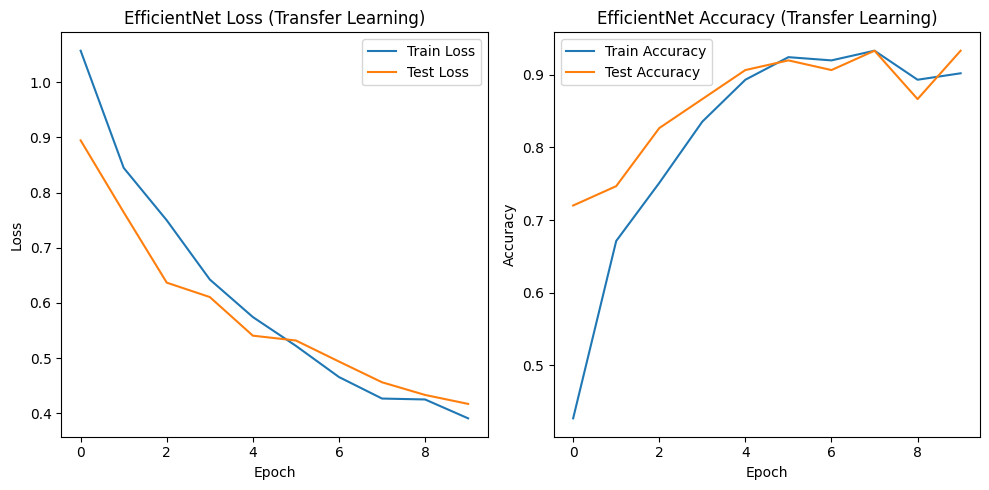

In [20]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer:**
2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer:**
3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer:**
4.  Choose 3 images from the test set. Display the images and show their predicted classes.

### Questions for Part 2:
1. Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
   * **Your Answer:** จากผลลัพธ์การทดสอบ EfficientNet_B0 ที่ใช้ Transfer Learning มีประสิทธิภาพที่ดีกว่า LeNet อย่างเห็นได้ชัด โดยมี Test Accuracy สูงถึง 93.33% ในขณะที่ LeNet มี Test Accuracy สูงสุดเพียง 52% เท่านั้น เหตุผลหลักมาจาก EfficientNet_B0 เป็นโมเดลที่ใหญ่กว่าและได้รับการฝึกฝนล่วงหน้าบนชุดข้อมูล ImageNet ขนาดใหญ่ ซึ่งมีคุณสมบัติในการสกัดคุณลักษณะ (feature extraction) ที่ดีกว่า LeNet มาก ทำให้สามารถนำความรู้ที่ได้จากการเรียนรู้บน ImageNet มาปรับใช้กับงานจำแนกภาพ Pizza, Steak, Sushi ได้อย่างมีประสิทธิภาพ แม้ว่าชุดข้อมูลของเราจะมีขนาดเล็กก็ตาม
2. Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
   * **Your Answer:** การ "Freezing" Layers ใน Transfer Learning คือการกำหนดให้พารามิเตอร์ (น้ำหนักและไบแอส) ของเลเยอร์บางส่วนในโมเดลที่ pretrained ไม่ได้รับการอัปเดตระหว่างกระบวนการฝึกฝน โดยทั่วไปแล้ว เราจะ Freezing เลเยอร์ส่วนต้นๆ ของโมเดล (Feature Extractor) ซึ่งทำหน้าที่เรียนรู้คุณลักษณะทั่วไปของภาพ เช่น ขอบ มุม หรือพื้นผิว และปล่อยให้เลเยอร์ส่วนท้ายๆ (Classifier หรือ Head) ซึ่งทำหน้าที่จำแนกคลาสได้รับการฝึกฝนใหม่
   * **เหตุผลที่ทำ:**
     * **ประหยัดทรัพยากรการคำนวณ:** การไม่ต้องคำนวณ gradients และอัปเดตพารามิเตอร์ในเลเยอร์ที่ Freezing ช่วยลดภาระการคำนวณลงได้มาก
     * **ป้องกัน Overfitting:** โดยเฉพาะอย่างยิ่งเมื่อใช้กับชุดข้อมูลขนาดเล็ก การ Freezing เลเยอร์ส่วนใหญ่ช่วยป้องกันไม่ให้โมเดลเรียนรู้ที่จะจำข้อมูลฝึกฝนมากเกินไป (memorize) และช่วยให้โมเดลสามารถ generalize ไปยังข้อมูลที่ไม่เคยเห็นได้ดีขึ้น
     * **ใช้ประโยชน์จากคุณลักษณะที่เรียนรู้แล้ว:** เลเยอร์ส่วนต้นๆ ของโมเดลที่ pretrained บนชุดข้อมูลขนาดใหญ่ เช่น ImageNet ได้เรียนรู้คุณลักษณะที่เป็นประโยชน์สำหรับการจดจำภาพทั่วไปอยู่แล้ว การ Freezing เลเยอร์เหล่านี้ช่วยให้เราสามารถนำคุณลักษณะเหล่านี้มาใช้ได้โดยตรงโดยไม่ต้องฝึกฝนใหม่ทั้งหมด
   * **ประโยชน์:** ช่วยให้เราสามารถฝึกฝนโมเดลที่มีประสิทธิภาพสูงได้ด้วยชุดข้อมูลขนาดเล็กและทรัพยากรการคำนวณที่จำกัด ทำให้ Transfer Learning เป็นเทคนิคที่มีประโยชน์อย่างยิ่งในงาน Computer Vision
3. What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
   * **Your Answer:** เมื่อใช้ Transfer Learning กับชุดข้อมูลที่มีความแตกต่างอย่างมากจากชุดข้อมูลที่โมเดล pretrained ได้รับการฝึกฝนมา (เช่น ภาพทางการแพทย์ vs. ImageNet) อาจเกิดความท้าทายดังนี้:
     * **คุณลักษณะที่เรียนรู้ไม่ตรงกัน:** เลเยอร์ส่วนต้นๆ ของโมเดล pretrained อาจเรียนรู้คุณลักษณะที่ไม่เกี่ยวข้องหรือไม่เหมาะสมกับชุดข้อมูลใหม่ เช่น คุณลักษณะที่สำคัญในภาพถ่ายทั่วไปอาจไม่สำคัญในภาพทางการแพทย์ ทำให้ประสิทธิภาพลดลง
     * **ความจำเป็นในการ Fine-tuning มากขึ้น:** หากชุดข้อมูลใหม่แตกต่างมาก อาจไม่เพียงพอที่จะฝึกฝนเฉพาะส่วน Classifier เท่านั้น แต่อาจต้องทำการ Fine-tuning (unfreeze บางเลเยอร์และฝึกฝนด้วย Learning Rate ที่ต่ำ) เลเยอร์ส่วนท้ายๆ ของ Feature Extractor ด้วย เพื่อปรับให้เข้ากับคุณลักษณะเฉพาะของชุดข้อมูลใหม่
     * **ความแตกต่างในการกระจายข้อมูล (Data Distribution Shift):** หากการกระจายของข้อมูลในชุดข้อมูลใหม่แตกต่างจาก ImageNet อย่างมาก โมเดล pretrained อาจให้ผลลัพธ์ที่ไม่ถูกต้อง
     * **ขนาดของชุดข้อมูลใหม่:** แม้ว่า Transfer Learning จะช่วยได้ในกรณีข้อมูลน้อย แต่ถ้าชุดข้อมูลใหม่มีขนาดเล็กมากจริงๆ การปรับเปลี่ยนโมเดล pretrained อาจยังคงมีความเสี่ยงที่จะเกิด Overfitting ได้
     * **ความต้องการการปรับเปลี่ยนสถาปัตยกรรม:** ในบางกรณีที่ความแตกต่างของข้อมูลมีมาก อาจจำเป็นต้องปรับเปลี่ยนสถาปัตยกรรมของโมเดล pretrained นอกเหนือจากการเปลี่ยนแค่ Classifier


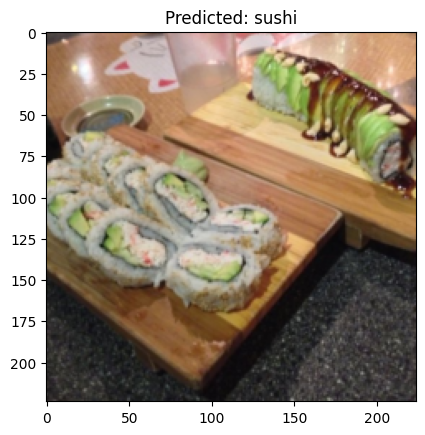

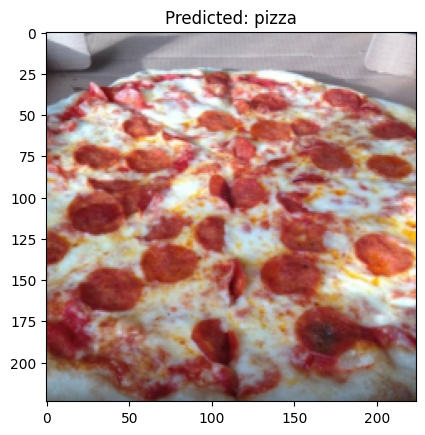

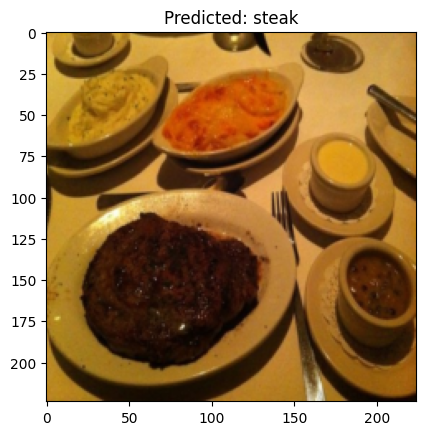

In [21]:
#4.Choose 3 images from the test set. Display the images and show their predicted classes.

# Choose 3 random images from the test set
import random
from PIL import Image

# Get a list of all image file paths in the test set
test_image_paths = []
for root, dirs, files in os.walk("test"):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            test_image_paths.append(os.path.join(root, file))

# Select 3 random image paths
random_image_paths = random.sample(test_image_paths, 3)

# Display images and their predictions
efficientnet_model.eval() # Set model to evaluation mode
with torch.no_grad():
    for img_path in random_image_paths:
        # Load and transform the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms(img).unsqueeze(0).to(device) # Add batch dimension and move to device

        # Make prediction
        output = efficientnet_model(img_tensor)
        _, predicted_class_index = torch.max(output.data, 1)
        predicted_class_name = class_names[predicted_class_index.item()]

        # Display the image and prediction
        plt.figure()
        imshow(img_tensor.cpu().squeeze(0), title=f"Predicted: {predicted_class_name}")
        plt.show()

In [22]:
# Example of making prediction on an image

x = torch.rand(1, 3, 224, 224)  # an image

prediction = efficientnet_model(x.to(device))

torch.argmax(prediction)



tensor(0, device='cuda:0')

$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$